# 作业第6周（1）循环神经网络练习

1.仿照课件关于IMDb数据集的分类训练，在课件示例模型基础上
改用GRU、优化网络层数与其它参数，提升分类准确率。<BR>

In [18]:
#首先执行GPU资源分配代码，勿删除。
import tensorflow as tf
from tensorflow import keras
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

#### 加载数据

In [19]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
import numpy as np

max_features = 20000
maxlen = 380
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=max_features)
print(len(x_train),"Training sequences")
print(len(x_val),"Validation sequences")

25000 Training sequences
25000 Validation sequences


In [20]:
len(x_train[0]), len(x_train[1]), y_train[0], y_train[1]

(218, 189, 1, 0)

In [21]:
word_index = keras.datasets.imdb.get_word_index (path='imdb_word_index.json')
word_index

{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951,
 'woods': 1408,
 'spiders': 16115,
 'hanging': 2345,
 'woody': 2289,
 'trawling': 52008,
 "hold's": 52009,
 'comically': 11307,
 'localized': 40830,
 'disobeying': 30568,
 "'royale": 52010,
 "harpo's": 40831,
 'canet': 52011,
 'aileen': 19313,
 'acurately': 52012,
 "diplomat's": 52013,
 'rickman': 25242,
 'arranged': 6746,
 'rumbustious': 52014,
 'familiarness': 52015,
 "spider'": 52016,
 'hahahah': 68804,
 "wood'": 52017,
 'transvestism': 40833,
 "hangin'": 34702,
 'bringing': 2338,
 'seamier': 40834,
 'wooded': 34703,
 'bravora': 52018,
 'grueling': 16817,
 'wooden': 1636,
 'wednesday': 16818,
 "'prix": 52019,
 'altagracia': 34704,
 'circuitry': 52020,
 'crotch': 11585,
 'busybody': 57766,
 "tart'n'tangy": 52021,
 'burgade': 14129,
 'thrace': 52023,
 "tom's": 11038,
 'snuggles': 52025,
 'francesco': 29114,
 'complainers': 52027,
 'templarios': 52125,
 '272': 40835,
 '273': 52028,
 'zaniacs': 52130,

In [22]:
index_to_word = {v:k for k,v in word_index.items()}
index_to_word

{34701: 'fawn',
 52006: 'tsukino',
 52007: 'nunnery',
 16816: 'sonja',
 63951: 'vani',
 1408: 'woods',
 16115: 'spiders',
 2345: 'hanging',
 2289: 'woody',
 52008: 'trawling',
 52009: "hold's",
 11307: 'comically',
 40830: 'localized',
 30568: 'disobeying',
 52010: "'royale",
 40831: "harpo's",
 52011: 'canet',
 19313: 'aileen',
 52012: 'acurately',
 52013: "diplomat's",
 25242: 'rickman',
 6746: 'arranged',
 52014: 'rumbustious',
 52015: 'familiarness',
 52016: "spider'",
 68804: 'hahahah',
 52017: "wood'",
 40833: 'transvestism',
 34702: "hangin'",
 2338: 'bringing',
 40834: 'seamier',
 34703: 'wooded',
 52018: 'bravora',
 16817: 'grueling',
 1636: 'wooden',
 16818: 'wednesday',
 52019: "'prix",
 34704: 'altagracia',
 52020: 'circuitry',
 11585: 'crotch',
 57766: 'busybody',
 52021: "tart'n'tangy",
 14129: 'burgade',
 52023: 'thrace',
 11038: "tom's",
 52025: 'snuggles',
 29114: 'francesco',
 52027: 'complainers',
 52125: 'templarios',
 40835: '272',
 52028: '273',
 52130: 'zaniacs',

In [23]:
" ".join([index_to_word[x] for x in x_train[0]])

"the as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room and it so heart shows to years of every never going and help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but pratfalls to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other tricky in of seen over landed for anyone of and br show's to whether from than out themselves history he name half some br of 'n odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but when from one bit the

#### 文字等长处理

In [24]:
x_train_pad = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val_pad = sequence.pad_sequences(x_val, maxlen=maxlen)

#### 建立模型

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Bidirectional
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [31]:
def gru():
    model = Sequential()
    model.add(Embedding(output_dim=300, input_dim=max_features, input_length=maxlen))
    model.add(Bidirectional(GRU(units=128,return_sequences=True)))
    model.add(Dropout(0.4))
    model.add(Bidirectional(GRU(units=64)))
    model.add(Dropout(0.4))
    model.add(Dense(units=64,activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(units=1,activation='sigmoid'))
    model.compile(loss="binary_crossentropy", optimizer=Adam(lr=1e-4, decay=1e-3), metrics=["accuracy"])
    return model

In [32]:
model = gru()
checkpointer = ModelCheckpoint(filepath="./save/3190105708_6_1_gru_latest.h5", monitor="val_accuracy", mode="max", verbose=1, save_best_only=True)
history = model.fit(x_train_pad, y_train, batch_size=64, epochs=10, verbose=1, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/10
313/313 [==============================] - ETA: 0s - loss: 0.6863 - accuracy: 0.5549
Epoch 00001: val_accuracy improved from -inf to 0.65660, saving model to ./save/3190105708_6_1_gru_latest.h5
313/313 [==============================] - 30s 96ms/step - loss: 0.6863 - accuracy: 0.5549 - val_loss: 0.6488 - val_accuracy: 0.6566
Epoch 2/10
313/313 [==============================] - ETA: 0s - loss: 0.3977 - accuracy: 0.8278
Epoch 00002: val_accuracy improved from 0.65660 to 0.87280, saving model to ./save/3190105708_6_1_gru_latest.h5
313/313 [==============================] - 29s 92ms/step - loss: 0.3977 - accuracy: 0.8278 - val_loss: 0.3111 - val_accuracy: 0.8728
Epoch 3/10
313/313 [==============================] - ETA: 0s - loss: 0.2094 - accuracy: 0.9247
Epoch 00003: val_accuracy improved from 0.87280 to 0.87620, saving model to ./save/3190105708_6_1_gru_latest.h5
313/313 [==============================] - 29s 92ms/step - loss: 0.2094 - accuracy: 0.9247 - val_loss: 0.3125 - v

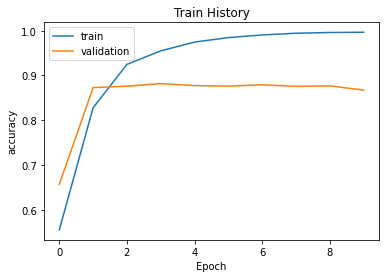

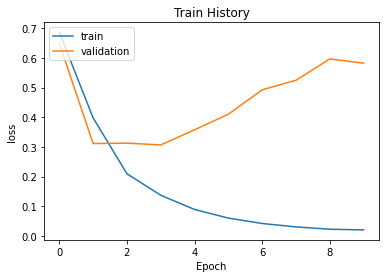

In [33]:
import matplotlib.pyplot as plt
def show_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train','validation'], loc='upper left')
    plt.show()

show_history(history, "accuracy", "val_accuracy")
show_history(history, "loss", "val_loss")

In [34]:
model = gru()
model.load_weights("save/3190105708_6_1_gru_latest.h5")
model.evaluate(x_val_pad, y_val, verbose=1)

782/782 [==============================] - 31s 39ms/step - loss: 0.3216 - accuracy: 0.8753


[0.321573406457901, 0.8753200173377991]